In [43]:
import sklearn
import xgboost
import pandas as pd
import numpy as np
from read_data import get_data_df
from preprocessing import (default_preprocessing, remove_constant_features, 
                           remove_missing_features, get_feature_labels,
                           remove_repeat_patients, impute_missing_value,
                           factorize, filter_most_corr
                          )
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

### Trace back feature names
We will need the feature names for the feature importance plots, so let's trace through the preprocessing steps to see which end up in the dataset used for training

In [48]:
df = get_data_df()

In [49]:
# Step through each preprocessing step & record column names
df = remove_repeat_patients(df, new_feature = True, return_type = 'dataframe')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,repeat_patient_count,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,1,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,1,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,Yes,1,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,Up,No,No,No,No,No,Ch,Yes,1,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,Steady,No,No,No,No,No,Ch,Yes,1,NO


In [50]:
# Save columns because after this, we swap to numpy arrays
df = remove_constant_features(df, return_type = 'dataframe')
df = remove_missing_features(df, threshold = 0.4, return_type = 'dataframe')
columns = df.columns
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,repeat_patient_count,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,1,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,Ch,Yes,1,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,Yes,1,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,Ch,Yes,1,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,Ch,Yes,1,NO


In [51]:
# Split train & test
data_x, data_y = get_feature_labels(df)

In [52]:
# imputs missing values
data_x = impute_missing_value(data_x)

# factorizes features
data_x = factorize(data_x)
data_x.shape

(71518, 44)

In [53]:
# At this point we know columns are still ordered, so we can put the imputed & factorized values into df
df = pd.DataFrame(data_x, columns=df.columns[:-1])

In [54]:
data_x = filter_most_corr(data_x, data_y, "correlation", 0.75)

In [55]:
data_x.shape

(71518, 32)

In [59]:
feature_names = []
for col in range(data_x.shape[1]):
    vals = data_x[:, col]
    for column in df.columns:
        if(np.array_equal(df[column].to_numpy(),vals)):
           feature_names.append(column)

In [60]:
len(feature_names)

32

In [61]:
feature_names[2:]

['race',
 'gender',
 'age',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'insulin',
 'change',
 'diabetesMed',
 'repeat_patient_count']

In [70]:
len(feature_names)

32

### Now use known feature names to explore feature importance scores from models

In [62]:
# Read input data & preprocess
# Note random seed included in train/test split in preprocessing so this train/test is same as grid search

df = get_data_df()
train_x, test_x, train_y, test_y = default_preprocessing(df)

In [63]:
rf = RandomForestClassifier(n_estimators = 250, max_depth = 25, min_samples_leaf = 10)
rf.fit(train_x, train_y)

xg = XGBClassifier(n_estimators = 20, max_depth = 5, max_leaves = 25, learning_rate = 0.5)
xg.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=25,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [64]:
# Double check trained model's AUC - matches Grid Search Metrics, which is great!
test_preds = rf.predict_proba(test_x)
print("Test AUC = " + str(roc_auc_score(test_y, test_preds, multi_class ='ovr')))

# Double check trained model's AUC - matches Grid Search Metrics, which is great!
test_preds = xg.predict_proba(test_x)
print("Test AUC = " + str(roc_auc_score(test_y, test_preds, multi_class ='ovr')))
      

Test AUC = 0.8566376847212854
Test AUC = 0.8575155343706844


In [65]:
# Impurity based scores
rf_impurity_scores = rf.feature_importances_[2:]

rf_impurity_all = (rf_impurity_scores - rf_impurity_scores.min(axis=0)) / (rf_impurity_scores.max(axis=0) - rf_impurity_scores.min(axis=0))

In [66]:
# permutation based scores
rf_permutation_scores = permutation_importance(rf, test_x, test_y, n_repeats=10, random_state=42)

In [67]:
rf_permutation_scores = rf_permutation_scores.importances_mean
rf_permutation_scores

array([ 6.33855332e-03,  2.73117077e-03,  1.72445936e-04,  3.54213274e-04,
        4.05480984e-04,  1.82233408e-03,  1.50074571e-03, -9.78747204e-05,
        1.43083520e-03,  9.32140194e-05,  7.45712155e-04,  6.99105145e-04,
        3.91498881e-04,  4.09209545e-03,  7.27069351e-04,  2.98284862e-04,
        1.81767338e-04,  1.18847875e-03,  6.52498136e-05,  2.65659955e-04,
        1.91088740e-04,  1.39821029e-05, -3.72856078e-05, -4.66070097e-05,
        1.81767338e-04, -1.86428039e-05,  0.00000000e+00,  0.00000000e+00,
        1.86428039e-05,  2.19052946e-04,  2.79642058e-04,  2.39518084e-01])

In [68]:
rf_permutation_all = (rf_permutation_scores - rf_permutation_scores.min(axis=0)) / (rf_permutation_scores.max(axis=0) - rf_permutation_scores.min(axis=0))

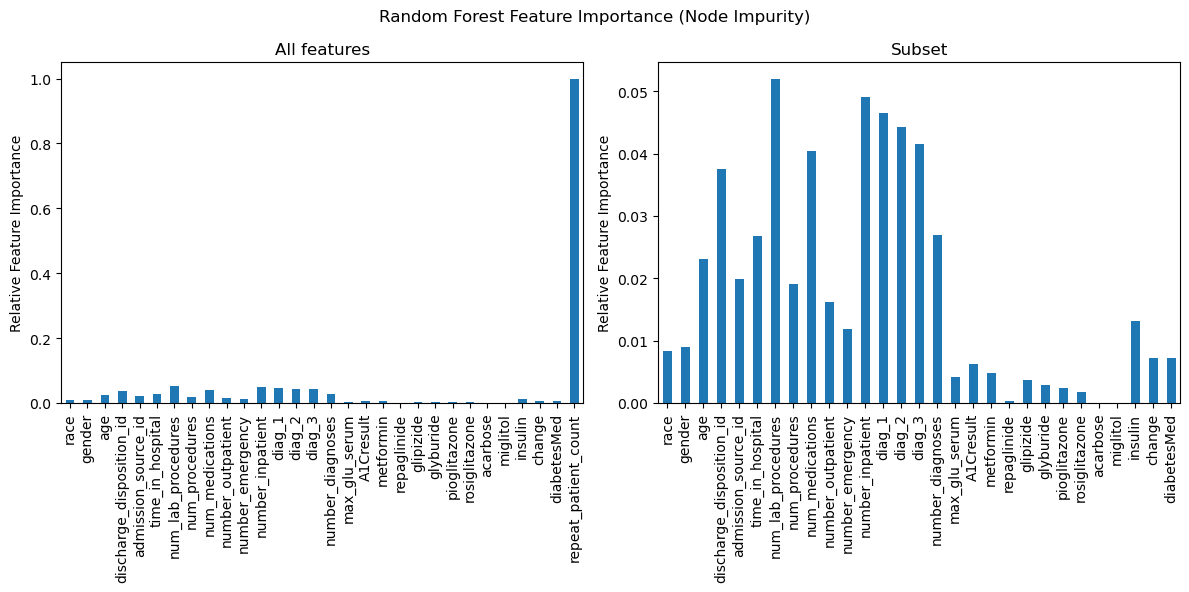

In [74]:
rf_importances = pd.Series(rf_impurity_all, index=feature_names[2:])
rf_importances_sub = pd.Series(rf_impurity_all[:-1], index=feature_names[2:-1])

rf_permutation = pd.Series(rf_permutation_all[2:], index=feature_names[2:])
rf_permutation_sub = pd.Series(rf_permutation_all[2:-1], index=feature_names[2:-1])

fig, ax = plt.subplots(1,2, figsize=(12,6))
rf_importances.plot.bar(ax=ax[0])
ax[0].set_title("All features")
ax[0].set_ylabel("Relative Feature Importance")
fig.tight_layout()

rf_importances_sub.plot.bar(ax=ax[1])
ax[1].set_title("Subset")
ax[1].set_ylabel("Relative Feature Importance")

fig.suptitle("Random Forest Feature Importance (Node Impurity)")
fig.tight_layout()

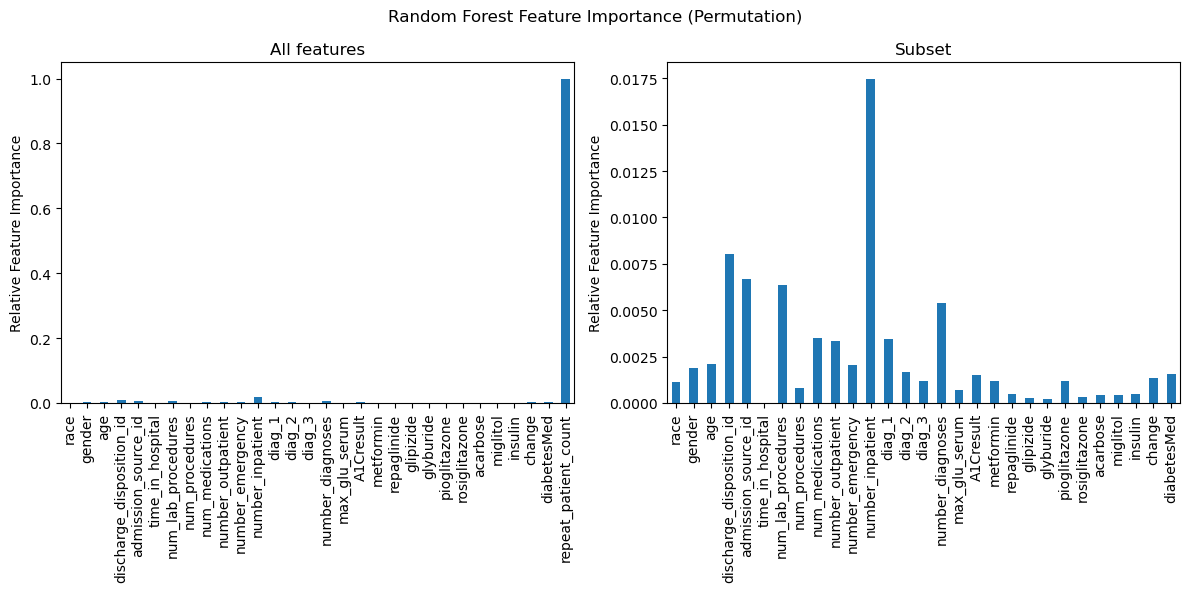

In [76]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
rf_permutation.plot.bar(ax=ax[0])
ax[0].set_title("All features")
ax[0].set_ylabel("Relative Feature Importance")
fig.tight_layout()

rf_permutation_sub.plot.bar(ax=ax[1])
ax[1].set_title("Subset")
ax[1].set_ylabel("Relative Feature Importance")

fig.suptitle("Random Forest Feature Importance (Permutation)")
fig.tight_layout()

In [77]:
# Impurity based scores
xg_impurity_scores = xg.feature_importances_[2:]

xg_impurity_all = (xg_impurity_scores - xg_impurity_scores.min(axis=0)) / (xg_impurity_scores.max(axis=0) - xg_impurity_scores.min(axis=0))

In [78]:
# permutation based scores
xg_permutation_scores = permutation_importance(xg, test_x, test_y, n_repeats=10, random_state=42)

In [79]:
xg_permutation_scores = xg_permutation_scores.importances_mean
xg_permutation_scores

array([ 1.96122297e-02,  6.44574944e-03,  2.14392245e-04,  5.59284116e-05,
        5.59284116e-05,  5.19668158e-03,  4.42766592e-04, -2.42356450e-04,
        9.32140194e-04, -2.09731544e-04,  5.59284116e-04,  1.81767338e-04,
        1.01603281e-03,  4.99627144e-03, -3.68195377e-04, -4.94034303e-04,
       -5.45302013e-04, -1.16517524e-04,  9.78747204e-05,  5.59284116e-05,
        1.86428039e-05, -2.22044605e-17,  1.39821029e-04,  4.66070097e-06,
       -4.19463087e-05,  7.92319165e-05, -7.45712155e-05,  0.00000000e+00,
       -1.86428039e-04, -1.49142431e-04, -2.47017151e-04,  2.38585943e-01])

In [80]:
xg_permutation_all = (xg_permutation_scores - xg_permutation_scores.min(axis=0)) / (xg_permutation_scores.max(axis=0) - xg_permutation_scores.min(axis=0))

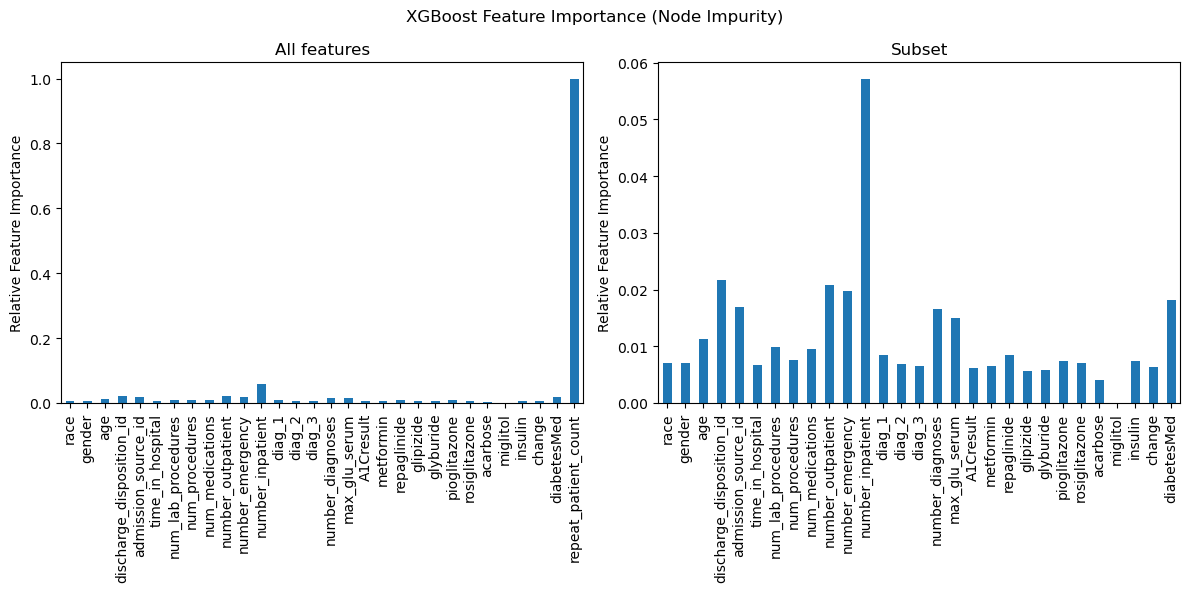

In [81]:
xg_importances = pd.Series(xg_impurity_all, index=feature_names[2:])
xg_importances_sub = pd.Series(xg_impurity_all[:-1], index=feature_names[2:-1])

xg_permutation = pd.Series(xg_permutation_all[2:], index=feature_names[2:])
xg_permutation_sub = pd.Series(xg_permutation_all[2:-1], index=feature_names[2:-1])

fig, ax = plt.subplots(1,2, figsize=(12,6))
xg_importances.plot.bar(ax=ax[0])
ax[0].set_title("All features")
ax[0].set_ylabel("Relative Feature Importance")
fig.tight_layout()

xg_importances_sub.plot.bar(ax=ax[1])
ax[1].set_title("Subset")
ax[1].set_ylabel("Relative Feature Importance")

fig.suptitle("XGBoost Feature Importance (Node Impurity)")
fig.tight_layout()

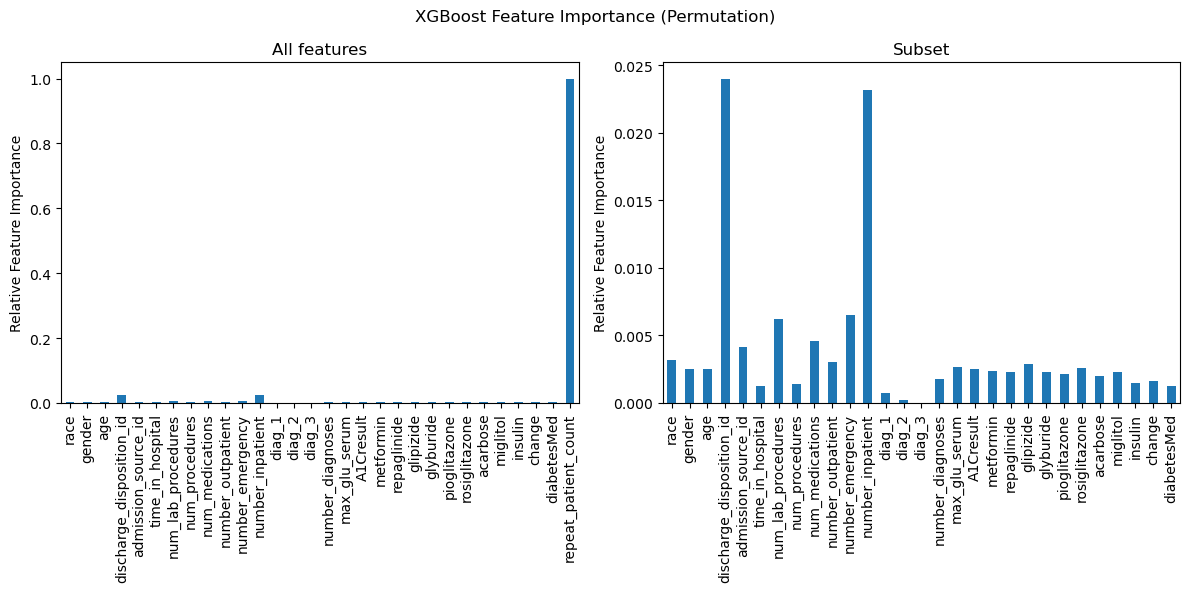

In [82]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
xg_permutation.plot.bar(ax=ax[0])
ax[0].set_title("All features")
ax[0].set_ylabel("Relative Feature Importance")
fig.tight_layout()

xg_permutation_sub.plot.bar(ax=ax[1])
ax[1].set_title("Subset")
ax[1].set_ylabel("Relative Feature Importance")

fig.suptitle("XGBoost Feature Importance (Permutation)")
fig.tight_layout()